In [1]:
import os
import numpy as np
import nbimporter
import matplotlib.pyplot as plt

% matplotlib inline

In [41]:
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from ResNet34 import ResnetBuilder
from DataParserForCNN import read_class, read_full_df, null_augment
from DataParserForCNN import ImageBatchGenerator
from albumentations import Rotate, Flip
# from StrokeRemoval import stroke_removal
from random import randint
import cv2


from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy

In [59]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [65]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [9]:
class_array = read_class()
base_path = 'C:/Users/IML/Desktop/QuickDrawDataset/'

In [66]:
K.set_image_dim_ordering('tf')
resnet50 = ResnetBuilder.build_resnet_50((3, 64, 64), 340)

In [11]:
full_df, train_id, valid_id = read_full_df(base_path, class_array)

	 load df   :  339/340                   zigzag   7 min 14 sec

	 load valid_set split:  339/340                   zigzag  13 min 22 sec

In [12]:
print(train_id.shape)
print(valid_id.shape)

(49680379, 3)
(27200, 3)


In [55]:
def stroke_removal(drawing, percent=0.35, alpha=0.5, beta=0.5):
    num = int(len(drawing) * percent)
    pi = []
    for i, stroke in enumerate(drawing):
        pi.append(np.exp(alpha * (i+1)) / np.exp(beta * len(stroke[0])))
    pi = pi / np.array(pi).sum()
    order_to_remove = np.argsort(pi)[::-1]
    temp = [drawing[j] for j, i in enumerate(drawing) if j in order_to_remove[num:]]
    return temp

In [51]:
def drawing_to_image(drawing, H, W):

    point=[]
    time =[]
    
    for t,(x,y) in enumerate(drawing):
        point.append(np.array((x,y),np.float32).T)
        time.append(np.full(len(x),t))

    point = np.concatenate(point).astype(np.float32)
    time  = np.concatenate(time).astype(np.int32)
    
    coords = []
    
    image  = np.full((H,W,3),0,np.uint8)
    x_max = point[:,0].max()
    x_min = point[:,0].min()
    y_max = point[:,1].max()
    y_min = point[:,1].min()
    w = x_max-x_min
    h = y_max-y_min
    #print(w,h)

    s = max(w,h)
    norm_point = (point-[x_min,y_min])/s
    norm_point = (norm_point-[w/s*0.5,h/s*0.5])*max(W,H)*0.85
    norm_point = np.floor(norm_point + [W/2,H/2]).astype(np.int32)

    T = time.max()+1
    for t in range(T):
        p = norm_point[time==t]
        x,y = p.T
        image[y,x]=255
        N = len(p)
        for i in range(N-1):
            x0,y0 = p[i]
            x1,y1 = p[i+1]
            coords.append((x0, y0))
            cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)
        coords.append((x1, y1))

    return image, coords

In [52]:
def random_augment(drawing, label, index):
    number = randint(1, 4)
    if number == 4:   # remove strokes
        drawing = stroke_removal(drawing, percent=0.35)
    image, _ = drawing_to_image(drawing, 64, 64)

    if number == 1:  # null augment
        image = image
    elif number == 2:      # random flip 
        image = Flip(p=1)(image=image)['image']
    elif number == 3:      # random rotate
        image = Rotate(p=1, border_mode=cv2.BORDER_CONSTANT)(image=image)['image']
    return image, label

In [53]:
def normalize(image):
    return image / 255.

train_batch = ImageBatchGenerator(
                 class_array=class_array,
                 full_df=full_df,
                 datasplit_id=train_id,
                 split='train_set',
                 batch_size=1024, 
                 augment=random_augment, 
                 mode='simplified', 
                 norm=normalize,
                 shuffle=True)

valid_batch = ImageBatchGenerator(
                 class_array=class_array,
                 full_df=full_df,
                 datasplit_id=valid_id,
                 split='valid_set',
                 batch_size=1024, 
                 augment=null_augment, 
                 mode='simplified', 
                 norm=normalize,
                 shuffle=True)

In [56]:
len(train_batch[0][1])

1024

In [9]:
def draw_a_batch(batch_size=16):
    fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))

    for i, ax in enumerate(m_axs.flatten()):
        img = train_batch[0][0][i]
        ax.imshow(img.astype('float'))
        ax.set_title(class_array[np.squeeze(np.where(train_batch[0][1][i] == 1))])

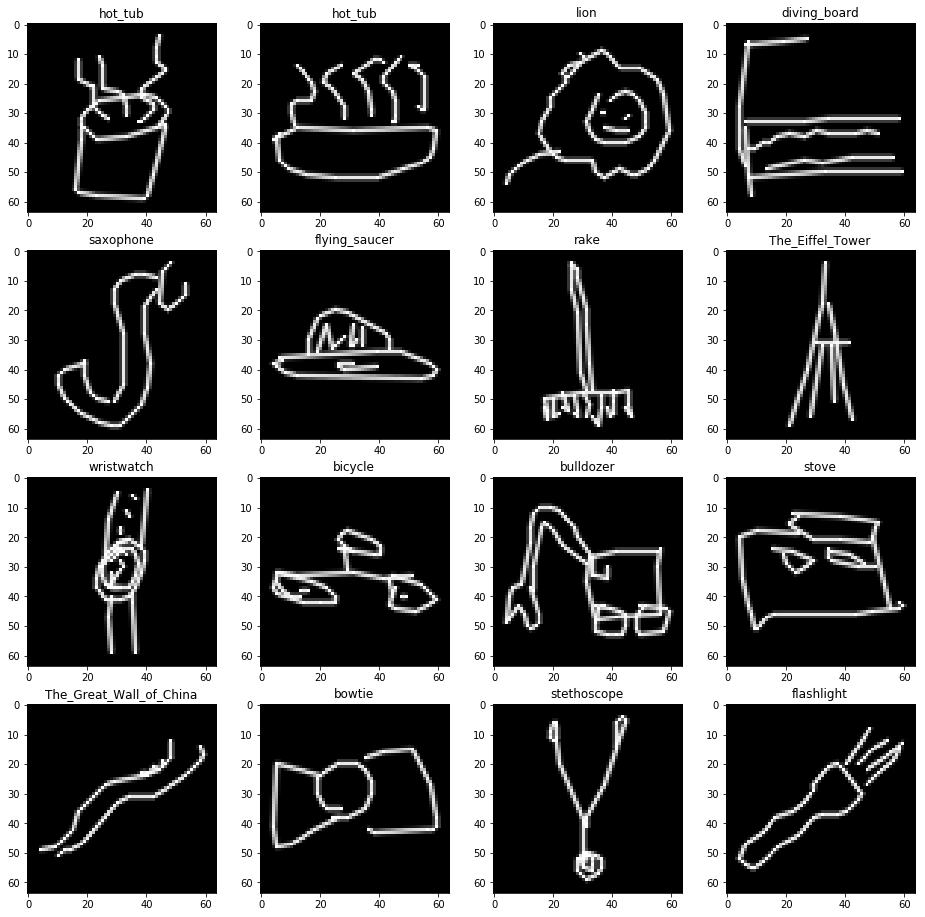

In [10]:
draw_a_batch()

In [15]:
class WeightSaver(Callback):
    def __init__(self, N):
        self.N = N
        self.batch = 0

    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            name = 'qd_rn50_weights%06d.h5' % self.batch
            self.model.save_weights(name)
        self.batch += 1

In [68]:
def top_3_accuracy(x, y): 
    return top_k_categorical_accuracy(x, y, 3)

def map3(x, y):
    return (top_k_categorical_accuracy(x, y, 3) + top_k_categorical_accuracy(x, y, 2)  + top_k_categorical_accuracy(x, y, 1))/3


def train(model):
#     print(model.summary())
    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               patience=3,
                               mode='min',
                               verbose=1)

    checkpoint = ModelCheckpoint('quick_draw_resnet50_1026.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 period=1)

    reduce_lr = ReduceLROnPlateau(patience=1, factor=0.6, monitor='val_loss', verbose=1)
    weightsaver = WeightSaver(300)  # save weights every 100 steps

    model.load_weights('./model/qd_rn50_weights090000.h5')

    # TODO: try different optimizer and tweak parameters (in MNv1 paper they used RMSprop)
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    # optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
    # optimizer = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy', 
                  metrics = ['acc', top_3_accuracy],
                  optimizer=optimizer)

    model.fit_generator(generator=train_batch,
                        steps_per_epoch=len(train_batch),
                        epochs=20,      # 100
                        verbose=1,
                        validation_data=valid_batch,
                        validation_steps=len(valid_batch),
                        callbacks=[early_stop, checkpoint, reduce_lr, weightsaver],
                        max_queue_size=3)

In [ ]:
train(resnet50)

Epoch 1/20
